In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import os
import sys
import re

import numpy as np
import pandas as pd

import json

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [149]:
data = pd.read_csv("/content/drive/MyDrive/Project/[SJU]창의학기제/lecture_evaluation_2021/data/review_not_dup-3-token.csv")

# 준지도학습
1. Teacher model 구축
  - training dataset(feature - review, label - rate)
  - biLSTM사용
  - data representation : glove
  - data augmentation : smote(보류)
2. pseudo dataset만들기 
  - 1번으로 학습한 모델에 문장단위(aspect는 한문장으로 등장한다고 본다.)로 모델 돌려서 pseudo label 구하기
  - 확률이 높은 pseudo-label data만 남기기
  - threshold : 85%
3. 1번과 2번 dataset을 합쳐서 re-training

In [150]:
data=data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [151]:
data.columns

Index(['like', 'semester', 'professor_name', 'rate', 'index', 'lecture_name',
       'url_id', 'duplicated', 'duplicated_id', 'clean_txt', 'aspect', 'cnt',
       '1', 'token'],
      dtype='object')

In [152]:
data.head()

,like,semester,professor_name,rate,index,lecture_name,url_id,duplicated,duplicated_id,clean_txt,aspect,cnt,1,token
0,0,20,이재교,100,0,법학입문,535020,0,-1,판례평석 잘하면 성적잘 주시는것 같음,학점,1,1.0,판례 평석 잘 면 성적 잘 시 는 음
1,1,20,오혜미,60,3,창업의이론과실제,2022697,0,-1,강의내용자체는 좋았어요 다만 원격강의로 진행되서 여러모로 불편한점이 많았습니다 출석...,수업,1,1.0,강의 내용 자체 는 좋 았 어요 다만 원격 강의 로 진행 서 여러모로 불편 점 많 ...
2,1,20,오혜미,20,4,창업의이론과실제,2022697,0,-1,강의 제목과 다르게 창업에 관한걸 배우는 것이 아니라 경영학 이론만 주구장창 암기시킴,수업,1,-1.0,강의 제목 과 다르 게 창업 에 관한 걸 배우 는 라 경영학 이론 만 주구장창 암기 시킴
3,0,19,오혜미,100,5,창업의이론과실제,2022697,0,-1,교수님 매우 착하시고 이쁘심 사랑해요 짱짱,교수,1,1.0,교수 님 매우 착하 시 고 이쁘 심 사랑 해요 짱짱
4,0,20,이유진,20,0,서양고전강독3,2100196,0,-1,1학점도 아까운 지옥의 강좌,학점,1,-1.0,학점 도 아까운 지옥 의 강좌


In [153]:
print("data 결측값 개수 :",data["token"].isnull().sum())
print("data개수:",len(data))
#data=data.dropna()
#print("data 결측값 삭제 후 결측값 개수:",data["token"].isnull().sum())
#print("data 결측값 삭제 후 데이터 개수:",len(data))

data 결측값 개수 : 0
data개수: 6998


In [154]:
#labeling 0 : [20,40,60] 1 : [80,100]
data = data[["1","token"]]
#data['rate'] = data['rate'].replace([20,30,60,80,100],[0,0,0,1,1])

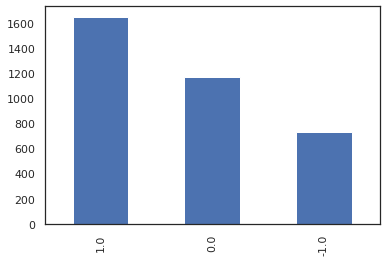

In [155]:
#label 분포 확인
data["1"].value_counts().plot(kind='bar')

In [156]:
print(data.groupby('1').size().reset_index(name='count'))

     1  count
0 -1.0    732
1  0.0   1168
2  1.0   1649


데이터 불균형으로 0의 데이터를 복제해서 비슷한 개수로 맞추어 사용!

In [157]:
duplicate_neg = data[data["1"]==0]
data=data.append(duplicate_neg,ignore_index=True)
print(data.groupby('1').size().reset_index(name='count'))

     1  count
0 -1.0    732
1  0.0   2336
2  1.0   1649


In [158]:
train_data = data[:3000]
train_data.tail()

,1,token
2995,-1.0,대답 는 게 부끄러워 거나 창 피해 는 학생 은 에이 플 은 못 받 을 듯
2996,1.0,매 수업 마다 수업 자료 열심히 만들 어 십니다
2997,1.0,맥코이 교수 님 은 좋 아요
2998,1.0,개 못했 는데 못한 거 에 비해 나쁘 은 학점 임
2999,-1.0,과제 다 진짜 열심히 했 는데 씨 플 잼


In [159]:
test_data = data[7000:]
len(test_data)

1166

In [160]:
#training, test dataset
#train_data, test_data = train_test_split(data,test_size=0.25,random_state=42)
#print('훈련용 리뷰의 개수:',len(train_data))
#print('테스트용 리뷰의 개수:',len(test_data))

# 긍정,부정 label기준으로 데이터 확인

In [161]:
minus_words = np.hstack(train_data[train_data["1"] == -1]['token'].str.split().values)
zero_words = np.hstack(train_data[train_data["1"] == 0]['token'].str.split().values)
plus_words = np.hstack(train_data[train_data["1"] == 1]['token'].str.split().values)

In [162]:
minus_word_count = Counter(minus_words)
print(minus_word_count.most_common(20))

[('는', 339), ('고', 229), ('수업', 172), ('도', 153), ('은', 150), ('에', 147), ('을', 146), ('과제', 117), ('다', 116), ('강의', 113), ('음', 103), ('게', 89), ('교수', 88), ('많', 88), ('시험', 83), ('안', 80), ('님', 74), ('듣', 66), ('를', 63), ('었', 62)]


In [163]:
zero_word_count = Counter(zero_words)
print(zero_word_count.most_common(20))

[('는', 604), ('고', 370), ('은', 322), ('에', 319), ('과제', 217), ('시험', 209), ('을', 207), ('도', 181), ('면', 181), ('다', 158), ('게', 152), ('수업', 151), ('음', 145), ('는데', 135), ('번', 131), ('강의', 129), ('를', 116), ('기', 111), ('문제', 109), ('잘', 108)]


In [164]:
plus_word_count = Counter(plus_words)
print(plus_word_count.most_common(20))

[('는', 631), ('고', 576), ('도', 406), ('님', 383), ('강의', 380), ('은', 378), ('교수', 372), ('에', 315), ('좋', 310), ('면', 295), ('수업', 294), ('을', 288), ('잘', 255), ('게', 254), ('시', 251), ('다', 214), ('만', 205), ('음', 194), ('학점', 163), ('었', 142)]


__positive, negative모두 많이 등장하는 것은 불용어로 처리함__

In [165]:
train_data.head()

,1,token
0,1.0,판례 평석 잘 면 성적 잘 시 는 음
1,1.0,강의 내용 자체 는 좋 았 어요 다만 원격 강의 로 진행 서 여러모로 불편 점 많 ...
2,-1.0,강의 제목 과 다르 게 창업 에 관한 걸 배우 는 라 경영학 이론 만 주구장창 암기 시킴
3,1.0,교수 님 매우 착하 시 고 이쁘 심 사랑 해요 짱짱
4,-1.0,학점 도 아까운 지옥 의 강좌


긍정 리뷰의 평균 토큰 개수 : 14.071890726096333
부정 리뷰의 평균 토큰 개수 : 15.005050505050505


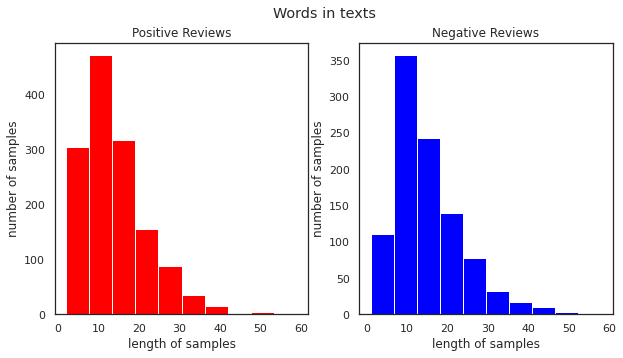

In [166]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['1']==1]['token'].map(lambda x: len(str(x).split())) #string으로 들어가있어서 split()해서 계산해야함
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 토큰 개수 :', np.mean(text_len))

text_len = train_data[train_data['1']==0]['token'].map(lambda x: len(str(x).split()))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 토큰 개수 :', np.mean(text_len))
plt.show()

In [167]:
X_train = list(train_data['token'])
y_train = pd.get_dummies(train_data['1']).values
X_test = list(test_data['token'])
y_test = pd.get_dummies(test_data['1']).values

In [168]:
X_train

['판례 평석 잘 면 성적 잘 시 는 음',
 '강의 내용 자체 는 좋 았 어요 다만 원격 강의 로 진행 서 여러모로 불편 점 많 았 습니다 출석 체크 꽤 철저 게 셨 어요 창업 에 관심 다면 어 볼 만 합니다 하지만 실무 적 인 내용 은',
 '강의 제목 과 다르 게 창업 에 관한 걸 배우 는 라 경영학 이론 만 주구장창 암기 시킴',
 '교수 님 매우 착하 시 고 이쁘 심 사랑 해요 짱짱',
 '학점 도 아까운 지옥 의 강좌',
 '그동안 고강 너무 날먹이 라 다 그걸 기대 고 수업 었 는데 그만큼 라서 실망 듯',
 '심화 학습 야 책 읽 고 써야 니 오래 걸릴 도 긴 한데 책 다 읽 어야 는 도 고 차 강의 부분 만 읽 으면 는데 이게 왜 그렇게 불만 인지 잘 모르 겠 음',
 '하도 이메일 로 찡찡 댔 는지 이것 마저 도 기말 에선 안 봄',
 '이메일 이나 공지 에서 보이 는 교수 님 태도 는 좀 심하 긴 셨 음',
 '난 아무것 도 게 고 과제 도 잘 했 는데 왜 혼나 는 기분 드 는지',
 '호불호 갈리 는 수업 인데 개인 적 으로 배울 건 정말 는 수업 라 생각 한다',
 '걍 제발 듣 고 도망가 다른 과목 였 어도 이교수 님 은 안 듣 는다',
 '아래 글 에서 수업 의 질 좋 았 다 어쩌구 는데 애초 에 수업 듣 고 고전 독서 를 막 탐구 고 싶 어서 듣 는 게 잖아',
 '수업 에 조금 만 더 신경 써 시 면 내용 적 인 측면 에서 더 배울 게 많 다고 생각 는데 많이 아쉽',
 '팀 플 역시 대충 구글링 만 해서 는 티 많이 날 밖에 음',
 '참고 로 쉐 라 톤 인턴 십 인터뷰 막힘없이 대답 할 었 던 이유 중 하나 수업 수강 했 기 때문 임',
 '호텔 산업 전반 에 대한 얕 고 넓 은 지식 을 습득 기 좋 은 강의 임',
 '밑 평가 왜 모양 인지 는 모르 겠 으나 이번 학기 전공 을 수강 했 던 으로서 가장 배울 점 많 은 강의 였 음',
 '교수 님 은 따뜻 신 편',
 '밑 에 수업 의 질 좋 다는 종이 님 인정 합니다',
 

In [169]:
max_len= max(len(str(l).split()) for l in X_train)
max_len

88

# 임베딩
- 사전학습된 glove사용

## about pre-trained glove
- 100차원
- [word, 임베딩]
- dictionary형태로

## pre-trained word embedding을 데이터에 매핑하는방법
1. 사전학습된 워드임베딩 가져오기
2. vocabulary만들기
3. index : vocabulary의 vocab의 인덱스

  value : vocab에 해당하는 사전학습된 워드임베딩 값

4. embedding층 만들기(100차원!!)


## 1. 사전학습된 glove 가져오기

In [170]:
#glove임베딩 미리보기
f = open('/content/drive/MyDrive/word-embeddings/glove/glove.txt', encoding="utf-8")
n=0
for line in f:
    glove_vector = line.split() # 각 줄을 읽어와서 glove_vector에 저장.
    print(glove_vector) # 각 줄을 출력
    word = glove_vector[0] # word_vector에서 첫번째 값만 저장
    print(word) # word_vector의 첫번째 값만 출력
    n=n+2
    if n==2:
        print("glove vector차원수:",len(glove_vector)-1) #차원 확인
        break
f.close()

['1', '-0.427017', '-0.543471', '0.195273', '0.294334', '-0.441908', '0.586086', '-1.443970', '-0.128346', '-0.419354', '-0.105046', '-0.062819', '0.817635', '-0.028393', '-0.536685', '-0.167379', '0.761647', '-0.703329', '-0.431556', '0.937837', '-0.018627', '3.201631', '-0.205946', '0.016677', '-0.789980', '0.844502', '0.444262', '0.486175', '0.325960', '-0.512402', '-0.365067', '0.279400', '0.698188', '0.669176', '0.108002', '-0.033698', '-0.579947', '-0.217866', '-0.007519', '-0.085234', '0.247842', '-0.027679', '-0.155354', '-0.550271', '0.428700', '0.726512', '-0.181266', '-0.290955', '-0.361739', '0.315148', '0.393573', '-0.068044', '-0.480445', '-0.024986', '-0.378388', '-1.012683', '-0.712691', '-0.341613', '0.779409', '0.105670', '0.077645', '0.433831', '0.555564', '0.299442', '0.606449', '0.138358', '0.418029', '0.629145', '-2.468571', '-1.224234', '0.278155', '0.506161', '-0.221058', '0.611521', '-0.299896', '0.367458', '0.010755', '1.388007', '0.031539', '0.215583', '-0.37

In [171]:
import numpy as np
embedding_dict = dict()
f = open('/content/drive/MyDrive/word-embeddings/glove/glove.txt', encoding="utf-8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

358043개의 Embedding vector가 있습니다.


## 2. Embedding matrix만들기
- 단어집합이랑 pre-trained glove 매핑하기 
- 'nice'의 정수 인덱스가 1 이므로 embeddding_matrix[1]에는 사전훈련된 모델에서 'nice'의 벡터값이 들어가 있어야 합니다.

    출처: https://ebbnflow.tistory.com/154 [Dev Log : 삶은 확률의 구름]

In [172]:
t = Tokenizer()
t.fit_on_texts(X_train)
vocab_size = len(t.word_index) + 1

print(vocab_size)
#["문장1","문장2",...,"문장n"] 리스트 형태로 들어가면 띄어쓰기로 split되고 단어집합을 만듦

3832


In [173]:
embedding_matrix = np.zeros((vocab_size, 100))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix)

(3832, 100)

In [174]:
for word, i in t.word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
    temp = embedding_dict.get(word) # 단어(key) 해당되는 임베딩 벡터의 100개의 값(value)를 임시 변수에 저장
    if temp is not None:
        embedding_matrix[i] = temp # 임수 변수의 값을 단어와 맵핑되는 인덱스의 행에 삽입

## 3. glove model에 넣을 데이터 
  1. 정수 인코딩
  2. padding

In [175]:
#정수인코딩
X_encoded = t.texts_to_sequences(X_train)
print(X_encoded)

[[2036, 2037, 17, 11, 92, 17, 16, 1, 15], [7, 47, 123, 1, 19, 38, 63, 142, 2038, 7, 32, 298, 93, 981, 762, 98, 26, 38, 29, 143, 521, 299, 2039, 12, 148, 63, 763, 4, 358, 170, 43, 252, 20, 84, 178, 2040, 36, 66, 47, 3], [7, 1466, 94, 556, 12, 763, 4, 764, 187, 216, 1, 40, 2041, 340, 20, 1174, 359, 2042], [9, 10, 114, 481, 16, 2, 2043, 115, 1175, 259, 982], [24, 5, 1176, 1467, 39, 1177], [2044, 557, 50, 2045, 40, 13, 640, 482, 2, 8, 23, 21, 522, 217, 865, 78], [1178, 1179, 270, 100, 131, 2, 600, 139, 523, 1468, 5, 91, 248, 100, 13, 131, 314, 1, 5, 2, 558, 7, 174, 20, 131, 65, 21, 641, 280, 392, 1469, 432, 17, 97, 81, 15], [2046, 983, 32, 1470, 2047, 163, 689, 1180, 5, 58, 866, 27, 454], [983, 249, 524, 67, 412, 1, 9, 10, 2048, 1, 72, 1471, 91, 148, 15], [253, 642, 5, 12, 2, 14, 5, 17, 42, 21, 280, 2049, 1, 601, 455, 163], [559, 483, 1, 8, 149, 116, 36, 30, 413, 99, 59, 1, 8, 40, 46, 375], [315, 690, 33, 2, 1181, 130, 54, 87, 281, 765, 10, 3, 27, 33, 867], [984, 271, 67, 8, 39, 484, 19, 3

In [176]:
max_len=max(len(l) for l in X_encoded)
print(max_len)

88


In [177]:
#padding!!!!안해주면 model 돌릴 때 오류남...!!!
X_train=pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train=np.array(y_train)
print(X_train)
print(y_train)

[[2036 2037   17 ...    0    0    0]
 [   7   47  123 ...    0    0    0]
 [   7 1466   94 ...    0    0    0]
 ...
 [3831    9   10 ...    0    0    0]
 [  85 1253   21 ...    0    0    0]
 [  14   13   49 ...    0    0    0]]
[[0 0 1]
 [0 0 1]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [1 0 0]]


## 4. 임베딩층 만들기
1. keras의 내장함수 Embedding()사용
2. pre-trained word embedding주입하기

### Embedding parameter
- vocab-size : 전체 단어 집합의 크기
- output_dim : 워드 임베딩 후 임베딩 벡터의 차원
- input_length : 입력 시퀀스의 길이

In [178]:
from tensorflow.keras.layers import Embedding, Dense,LSTM, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
e = Embedding(vocab_size, 100, input_length=max_len) #pre-trained모델이므로 trainable = False로 더이상 훈련하지 않도록

# biLSTM 모델 학습

In [179]:
model.add(e)
model.add(LSTM(100, dropout = 0.1,recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 88, 100)           383200    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 303       
Total params: 463,903
Trainable params: 463,903
Non-trainable params: 0
_________________________________________________________________


In [180]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [181]:
#모델 컴파일하고 훈련
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, 
                    epochs=15, 
                    verbose=2, 
                    batch_size=512,
                    validation_split = 0.2)

Epoch 1/15
5/5 - 8s - loss: 0.6752 - acc: 0.4154 - val_loss: 0.6632 - val_acc: 0.5200
Epoch 2/15
5/5 - 5s - loss: 0.6536 - acc: 0.4504 - val_loss: 0.6009 - val_acc: 0.5200
Epoch 3/15
5/5 - 5s - loss: 0.6185 - acc: 0.4504 - val_loss: 0.5925 - val_acc: 0.5200
Epoch 4/15
5/5 - 5s - loss: 0.6187 - acc: 0.4504 - val_loss: 0.5924 - val_acc: 0.5200
Epoch 5/15
5/5 - 5s - loss: 0.6181 - acc: 0.4504 - val_loss: 0.6282 - val_acc: 0.5200
Epoch 6/15
5/5 - 5s - loss: 0.6228 - acc: 0.4508 - val_loss: 0.5943 - val_acc: 0.5183
Epoch 7/15
5/5 - 5s - loss: 0.6142 - acc: 0.4504 - val_loss: 0.6027 - val_acc: 0.5183
Epoch 8/15
5/5 - 5s - loss: 0.6144 - acc: 0.4525 - val_loss: 0.5885 - val_acc: 0.5183
Epoch 9/15
5/5 - 5s - loss: 0.6224 - acc: 0.4512 - val_loss: 0.5897 - val_acc: 0.5217
Epoch 10/15
5/5 - 5s - loss: 0.6145 - acc: 0.4496 - val_loss: 0.6027 - val_acc: 0.5183
Epoch 11/15
5/5 - 5s - loss: 0.6158 - acc: 0.4504 - val_loss: 0.5899 - val_acc: 0.5167
Epoch 12/15
5/5 - 5s - loss: 0.6178 - acc: 0.4517 - 

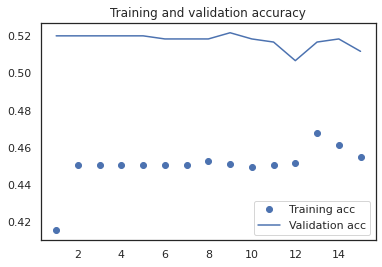

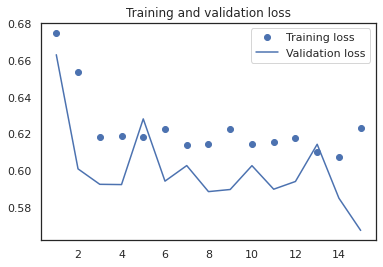

In [182]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [183]:
X_encoded = t.texts_to_sequences(X_test)
X_test=pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_test = pd.get_dummies(test_data['1']).values

In [184]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=-1) # 예측된 정수 시퀀스로 변환
y_predicted

array([2, 2, 2, ..., 2, 2, 2])

In [185]:
unique, counts = np.unique(y_predicted, return_counts=True)
dict(zip(unique, counts))

{0: 3, 1: 97, 2: 1066}

In [186]:
from sklearn.metrics import classification_report
y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=-1) # 예측된 정수 시퀀스로 변환

print('accuracy:', sum(y_predicted == y_test)/len(y_test))
print('Precision, Recall and F1-Score:\n\n', classification_report(y_test, y_predicted))

accuracy: [0. 0. 0. ... 0. 0. 0.]
Precision, Recall and F1-Score:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.08      0.15      1166
           2       0.00      0.00      0.00         0

    accuracy                           0.08      1166
   macro avg       0.33      0.03      0.05      1166
weighted avg       1.00      0.08      0.15      1166



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# pseudo label 구하기
- 문장단위
- tokenization : 형태소
- stopwords 동일하게 사용
- 예측값 pseudo-label 넣기

In [187]:
#pseudo data 전처리된 데이터 불러오기
pseudo_data = pd.read_csv("/content/drive/MyDrive/Project/[SJU]창의학기제/lecture_evaluation_2021/data/pseudo_dataset_token.csv")

FileNotFoundError: ignored

In [ ]:
pseudo_data["token"] = X_pseudo
pseudo_data["token"] = pseudo_data["token"].str.split()

X_pseudo_encoded = t.texts_to_sequences(pseudo_data["token"])
max_len=max(len(l) for l in X_pseudo_encoded)
X_pseudo=pad_sequences(X_pseudo_encoded, maxlen=max_len, padding='post') #maxlen= max_len에서 이전에 학습한 padding값과 너무 차이가 나서 결과가 안좋을 거 같음....


In [ ]:
pseudo_predict = model.predict(X_pseudo)

In [ ]:
pseudo_label = model.predict_classes(X_pseudo)

In [ ]:
pseudo_data["pseudo_predict"] = pseudo_predict
pseudo_data["pseudo_label"] = pseudo_label

In [ ]:
pseudo_data.head(50)

In [ ]:
pseudo_data['pseudo_label'] = pseudo_label

In [ ]:
pseudo_data.to_csv("/content/drive/MyDrive/Project/[SJU]창의학기제/lecture_evaluation_2021/data/pseudo_label.csv")